In [2]:
import torch
from torch.autograd import Variable
from functorch import vmap
import matplotlib.pylab as plt
import numpy as np
import scipy.stats as ss

import random

In [3]:
import sys
sys.path.insert(0,'vp_class/')

In [4]:
from class_ou import OU, ou_gradient
from class_tOU_v2 import tOU, tou_gradient

This code applies variational inference based on time-dependent OU processes to the observations drawn from the double well system SDE, as defined below. Note that we have chosen observational noise, i.e. variance of Gaussian noise and SDE variance to be 0.64 and 0.01 repectively.

m(t) = $\alpha$t + $m_{0}$

1. Simulate prior process, i.e. double-well system whose SDE is given by

$dX_{t} = 4X_{t}(1-X^{2}_{t})dt + \sigma dW_{t}$

In [5]:
import pickle

In [6]:
with open('EX03_DW_Model', 'rb') as f:
    prior = pickle.load(f)
    likelihood = pickle.load(f)


In [18]:
true_sde_pts, true_sde_trj = prior[0], prior[1]
obs, obs_time = likelihood[0], likelihood[1]
sde_sigma = 0.8 # Variance is higher than the original example
obs_sigma = 0.1

In [8]:
def prior_drift (s, x_s):
    return 4 * x_s * (1 - (x_s ** 2))

**Generate observations from Gaussian likelihood**

# Time step the SDE: dot X = -mu X + sigma xi, by Euler's method.

# Problem setup. 
# Set model and numerical parameters, and the initial condition.
# These are the lines the user might want to vary.
tf = 8
Nsteps = 800
Npaths = 1
X0 = 1
sde_sigma = 0.8 # Variance is higher than the original example
obs_sigma = 0.1

# Generate the time grid and solution array
t, dt = np.linspace(0,tf,Nsteps+1,retstep=True)
X = np.zeros((Nsteps+1,Npaths))
root_dt = np.sqrt(dt)
  
# Time step starting from initial condition
X[0,:] = X0;

for n in range(Nsteps):
    F_of_X = 4 * X[n,:] * (1 - (X[n,:] ** 2))
    X[n+1,:] =  X[n,:] + dt * F_of_X + sde_sigma * root_dt * np.random.randn(Npaths)

# Observations with Gaussian noise
obs = np.random.normal(loc = X[::100], scale = obs_sigma)
obs_time = t[::100]

true_sde_pts = torch.from_numpy(t)
true_sde_trj = torch.from_numpy(X.flatten())

obs = torch.from_numpy(obs)
obs_time = torch.from_numpy(obs_time)

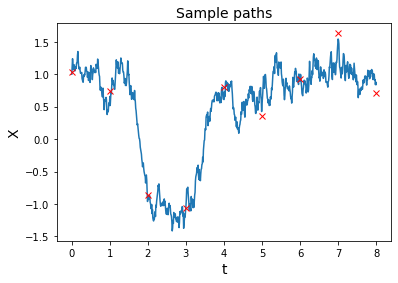

In [9]:
# Plot paths
plt.plot(true_sde_pts,true_sde_trj)
plt.plot(obs_time, obs, "rx")
plt.xlabel("t", fontsize=14)
plt.ylabel("X", fontsize=14)
plt.title("Sample paths", fontsize=14)
plt.show()


Variational inference: KL

2. Implement Variational inference based on $\textbf{time-inhomogeneous}$ OU process with SDE:

$$dZ_t = [-r(Z_t - m(t)) + m'(t)]dt + \sigma dW_t$$

$$\mathbb{E}_{P^{Z}}[\log\exp{\frac{dP^{X}}{dP^{Z}}(Z)] = \frac{1}{2}\mathbb{E}_{P^{Z}}[\int_{t_{0}}}^{t_{1}}|\frac{4Z_{t}(1-Z^{2}_{t}) + r(Z_{t}-m(t))-m'(t)}{\sigma}|^{2}dt]$$

where the relevant functions

$$m(t) = \alpha (B(t, \beta) - 1) + m_{0}$$

$$m'(t) = \alpha \beta B(t, \beta - 1)$$

$$B(s, \beta) = (s + 1)^{\beta}$$

The mean and variance of the process have a tracatble expression: $E(Z_t) = m(t), Var(Z_t) = \frac{\sigma^{2}}{2r}(1-e^{-2rt})$

Here we consider a variational process with a $\textbf{linear mean function}$, i.e. $\beta = 1$, which results in $m(t) = \alpha t + m_{0}$. Our variational parameters, thus, include $r, \alpha$. 

In [19]:
class ELBO:
    """
        ELBO with
            variational process (q): time-inhomogeneous OU process
            prior process (p): double-well system
            
        This class computes: - KL(q|p) + NLL(y|z)  where z \sim q
    """
    def __init__(self, ou):
        self.ou = ou
        self.alpha = ou.alpha
        self.beta = ou.beta
        self.sigma = ou.sigma
        self.r = ou.r
        self.m0 = ou.m0
    
    def KL(self, prior_drift):
        """
            This function requires the function corresponding to prior drift function
        """
        # Save parameter specification from ou class
        alpha, beta, sigma, r, m0 = self.alpha, self.beta, self.sigma, self.r, self.m0
        
        def B(s, beta):
            return (s+1) ** beta
        
        def m(s):
            return alpha * (B(s, beta) - 1) + m0
            
        def m_(s):
            return alpha * beta * B(s, beta-1)
        
        t = self.ou.pts - self.ou.pts[:, 0].reshape(-1, 1)
        
        # Evaluate the drift function of the approximating processes
        g_of_x = -r * (self.ou.trj - m(t)) + m_(t)
        
        # Evaluate the drift function of the model (prior process)
        f_of_x = prior_drift(t, self.ou.trj)
        
        # Compute the term inside the KL divergence
        
        F_of_X = abs(((f_of_x - g_of_x) / sigma) ** 2)
        
        return 0.5 * torch.trapezoid(F_of_X, x=t).reshape(-1, 1)
         
    def log_prob(self, obs, obs_sigma):
        """
            Compute the log-likelihood
            likelihood function is normal density N(obs, var)
            obs.shape = D * 1 (D: # of sample)
        """
        def log_pdf(obs, z, obs_sigma):
            return ss.norm.logpdf(obs, loc=z, scale=obs_sigma)
            
        return torch.from_numpy(log_pdf(obs, self.ou.trj[:, -1].reshape(-1, 1), obs_sigma))


**Variational inference: a piece-wise approximation**

In [20]:
import tqdm as tq

In [21]:
def score_estimate(s0, sK, m0, pars, sigma, obs, obs_sigma, M):
    """
        Returns stochastic estimates of the gradient of the ELBO with respect to parameters including
            alpha, r, beta
        
        M: # of Monte Carlo samples
        
    """
    
    assert obs.shape[0] == 1, "observation must be 1-d torch.array"
    
    # Number of time points drawn between s0 and sK
    K = 200
    
    alpha = pars['alpha']
    r = pars['r']
    
    if 'beta' in pars.keys():
        beta = pars['beta']
    else:
        beta = torch.tensor([1.])
    
    # Reshape every parameter into (M,1) torch.array
    ALPHA = alpha.repeat(M, 1)
    BETA = beta.repeat(M, 1)
    R = r.repeat(M, 1)
    SIGMA = sigma.repeat(M, 1)
    OBS = obs.repeat(M, 1)
    m0 = m0.repeat(M, 1)
    

    # Simulate sample path
    # Note that z0 = m0
    vi = tOU(t0=s0, t1=sK, m0=m0, alpha=ALPHA, beta=BETA, sigma=SIGMA, r=R, dN=K, timegrid = 'False')

    # Compute the ELBO 
    elbo = ELBO(vi)
    score_func = tou_gradient(vi.pts, vi.trj, torch.stack([ALPHA, BETA, R, m0, SIGMA]).view(-1, M, 1))
    f_of_X = -elbo.log_prob(OBS, obs_sigma) + elbo.KL(prior_drift)

    # Get stochastic estimate of the gradient with respect to each parameter
    alpha_grad = torch.nanmean(f_of_X * score_func['alpha'])
    r_grad = torch.nanmean(f_of_X * score_func['r'])
    
    if 'beta' not in pars.keys():
        stochastic_gradient = {'alpha':alpha_grad, 'r':r_grad}
    else:
        beta_grad = torch.nanmean(f_of_X * score_func['beta'] )
        stochastic_gradient = {'alpha':alpha_grad, 'beta':beta_grad, 'r':r_grad}
    
    
    return stochastic_gradient

In [22]:
def AdaGrad( current_pars, current_grad, past_grad, learning_rate = 0.01, smooth_term = 1e-8):
    """
        Perform one-step gradient descent based on AdaGrad
    """
    assert type(current_pars) == type(current_grad) == type(past_grad) == dict, "Current_grad must be a dict"
    
    
    new_pars = {}
    for key in current_pars.keys():
        if key == 'r':
            new_pars[key] = current_pars[key] - learning_rate / np.sqrt(past_grad[key] + smooth_term) * current_grad[key]
            value = new_pars[key]
            while value <= 0:
                value = current_pars[key] - learning_rate / np.sqrt(past_grad[key] + smooth_term) * current_grad[key]
                learning_rate *= 0.5
            
            new_pars[key] = value
  
        else:
            new_pars[key] = current_pars[key] - learning_rate / np.sqrt(past_grad[key] + smooth_term) * current_grad[key]

    return new_pars
    
    

In [23]:
def Grad_Descent( current_pars, current_grad, past_grad, learning_rate = 0.01):
    """
        Perform vanila gradient descent step
        returns dictionary such that dict["name_of_parameter"] = value after one gradient step
    """
    assert type(current_pars) == type(current_grad) == type(past_grad) == dict, "Current_grad must be a dict"
    
    
    new_pars = {}
    for key in current_pars.keys():
        if key == 'r':
            new_pars[key] = current_pars[key] - learning_rate * current_grad[key]
            value = new_pars[key]
            while value <= 0:
                value = current_pars[key] - learning_rate * current_grad[key]
                learning_rate *= 0.5
            new_pars[key] = value
  
        else:
            new_pars[key] = current_pars[key] - learning_rate * current_grad[key]

    return new_pars
    

In [24]:
def get_PostMoment(t0, tT, alpha, beta, m0, r, sigma, vN):
    """
        Returns mean and variance of the approximate posterior process
        Here, we 
        Note: mean and variance have tractable expressions
    """
    # Get time-grid between s0 and sK
    
    t = torch.linspace(0, (tT-t0).item(), vN+2)[1:]
    
    def B(s, beta):
        return (s+1) ** beta
        
    def m(s):
        return alpha * (B(s, beta) - 1) + m0
    
    
    mean = m(t)
    

    def var(s):
        return sigma ** 2 / (2 * r) * (1 - torch.exp(-2 * r * s))

    var = var(t)
        
    return t, mean, var

**To be added: 1. parameter update history, 2. elbo, KL, and loglikelihood estimate, 3. randomizing initial state**

In [25]:
def Optimize(sde_sigma, obs, obs_time, obs_sigma, M, IT, vN, learning_rate, Linear = True, IsAda=False):
    """
        vN: # of time points between in each obs interval on which mean of the approximate posterior process will be evaluated
    """
    assert type(sde_sigma) == torch.Tensor, "SDE sigma must be a torch.Tensor"
    assert type(obs) == torch.Tensor, "obs must be a torch.Tensor"

    
    if Linear == True:
        # Two parameters: alpha, r
        init_pars = torch.tensor([-0.01, 3.])
        
    else:
        # Three parameters, alpha, beta, r
        init_pars = torch.randn(3)
        init_pars[2] = abs(init_pars[2])
#         init_pars = torch.tensor([-0.01, 1., 2.])
        
    N_of_Pars = init_pars.shape[0]
    T = obs.shape[0]
    
    v_N = T * (vN+1) - vN
    
    track_pars = np.zeros((N_of_Pars, T-1, IT))
    
    VP_PTS = np.zeros(v_N)
    VP_MEAN = np.zeros(v_N)
    VP_STD = np.zeros(v_N)
    
    # Intialize the state at the first observation
    m0 = obs[0]
    VP_MEAN[0] = m0
    
    
    

    for t in tq.tqdm(range(1, T)):
        s0 = obs_time[t-1]
        sK = obs_time[t]

        # Initialize a set of parameters
        if Linear == True:
            alpha, r = init_pars
            current_pars = {'alpha':alpha, 'r':r}
            beta = torch.tensor([1.])
        else:
            alpha, beta, r = init_pars
            current_pars = {'alpha':alpha, 'beta':beta, 'r':r}
        
        past_grad = {key:torch.tensor([0.01]) for key in current_pars.keys()}
        for i in range(IT):
            if i % (IT/2) == 0:
                print(i, current_pars)
            # Take gradient descent algorithm based on AdaGrad

            # Obtain stochastic estimate of the gradients based on score function estimator
            current_grad = score_estimate(s0, sK, m0, current_pars, sde_sigma, obs[t], obs_sigma, M)

            # Take one gradient step based on the AdaGrad
            if IsAda == True:
                current_pars = AdaGrad(current_pars, current_grad, past_grad, learning_rate, smooth_term = 1e-8)
                
                # Save the current gradient estimate
                for key in current_grad.keys():
                    past_grad[key] += current_grad[key] ** 2
            else:
                current_pars = Grad_Descent(current_pars, current_grad, past_grad, learning_rate)
            
            track_pars[0, t-1, i] = current_pars['alpha'].item()
            track_pars[1, t-1, i] = current_pars['r'].item()
            track_pars[2, t-1, i] = current_pars['beta'].item()
            
        alpha = current_pars['alpha']
        r = current_pars['r']
        if Linear == False:
            beta = current_pars['beta']
        
        # Obtain moments of approximating processes (note that their forms are tractable)
        vp_pts, vp_mean, vp_var = get_PostMoment(s0, sK, alpha, beta, m0, r, sde_sigma, vN)
        
        VP_PTS[(vN+1)*(t-1)+1:(vN+1)*t+1] = obs_time[t-1].item() + vp_pts
        VP_MEAN[(vN+1)*(t-1)+1:(vN+1)*t+1] = vp_mean
        VP_STD[(vN+1)*(t-1)+1:(vN+1)*t+1] = vp_var
        
        m0 = vp_mean[-1]
        
        print("observation: " + str(obs[t].item()) + " variational mean: " + str(m0.item()))
    return VP_PTS, VP_MEAN, VP_STD, track_pars

In [26]:
vp_pts, vp_mean, vp_std, vp_pars = Optimize(torch.tensor([sde_sigma]), obs, obs_time, obs_sigma, M=1000, IT=300, vN=200, learning_rate=0.001, Linear = False, IsAda=False)

  0%|                                                     | 0/8 [00:00<?, ?it/s]

0 {'alpha': tensor(-0.9012), 'beta': tensor(0.4223), 'r': tensor(0.3290)}
150 {'alpha': tensor(-0.9740, dtype=torch.float64), 'beta': tensor(0.4755, dtype=torch.float64), 'r': tensor(2.1148, dtype=torch.float64)}


 12%|█████▋                                       | 1/8 [00:19<02:13, 19.05s/it]

observation: 0.7418740051633642 variational mean: 0.6905090798361055
0 {'alpha': tensor(-0.9012), 'beta': tensor(0.4223), 'r': tensor(0.3290)}
150 {'alpha': tensor(-1.2889, dtype=torch.float64), 'beta': tensor(1.1231, dtype=torch.float64), 'r': tensor(1.9484, dtype=torch.float64)}


 25%|███████████▎                                 | 2/8 [00:37<01:53, 18.97s/it]

observation: -0.8564873337841266 variational mean: -0.8498083353042603
0 {'alpha': tensor(-0.9012), 'beta': tensor(0.4223), 'r': tensor(0.3290)}
150 {'alpha': tensor(-0.7838, dtype=torch.float64), 'beta': tensor(0.0632, dtype=torch.float64), 'r': tensor(2.3211, dtype=torch.float64)}


 38%|████████████████▉                            | 3/8 [00:56<01:34, 18.99s/it]

observation: -1.0673319792395932 variational mean: -0.9383479952812195
0 {'alpha': tensor(-0.9012), 'beta': tensor(0.4223), 'r': tensor(0.3290)}
150 {'alpha': tensor(-2.3773, dtype=torch.float64), 'beta': tensor(-1.8621, dtype=torch.float64), 'r': tensor(1.9499, dtype=torch.float64)}


 50%|██████████████████████▌                      | 4/8 [01:15<01:15, 19.00s/it]

observation: 0.7995340035602375 variational mean: 0.8237791657447815
0 {'alpha': tensor(-0.9012), 'beta': tensor(0.4223), 'r': tensor(0.3290)}
150 {'alpha': tensor(-0.9895, dtype=torch.float64), 'beta': tensor(0.5791, dtype=torch.float64), 'r': tensor(1.8182, dtype=torch.float64)}


 62%|████████████████████████████▏                | 5/8 [01:34<00:56, 18.97s/it]

observation: 0.3540452486520327 variational mean: 0.33382511138916016
0 {'alpha': tensor(-0.9012), 'beta': tensor(0.4223), 'r': tensor(0.3290)}
150 {'alpha': tensor(-1.1785, dtype=torch.float64), 'beta': tensor(-0.7709, dtype=torch.float64), 'r': tensor(2.0104, dtype=torch.float64)}


 75%|█████████████████████████████████▊           | 6/8 [01:53<00:37, 18.95s/it]

observation: 0.9328201877376548 variational mean: 0.8685243129730225
0 {'alpha': tensor(-0.9012), 'beta': tensor(0.4223), 'r': tensor(0.3290)}
150 {'alpha': tensor(-0.9849, dtype=torch.float64), 'beta': tensor(-0.4721, dtype=torch.float64), 'r': tensor(2.6733, dtype=torch.float64)}


 88%|███████████████████████████████████████▍     | 7/8 [02:12<00:18, 18.96s/it]

observation: 1.6311081388826472 variational mean: 1.1969420909881592
0 {'alpha': tensor(-0.9012), 'beta': tensor(0.4223), 'r': tensor(0.3290)}
150 {'alpha': tensor(-1.1012, dtype=torch.float64), 'beta': tensor(0.6196, dtype=torch.float64), 'r': tensor(2.1687, dtype=torch.float64)}


100%|█████████████████████████████████████████████| 8/8 [02:31<00:00, 18.99s/it]

observation: 0.708966867981579 variational mean: 0.658740758895874


Approximate Posterior process; its mean and standard deviation

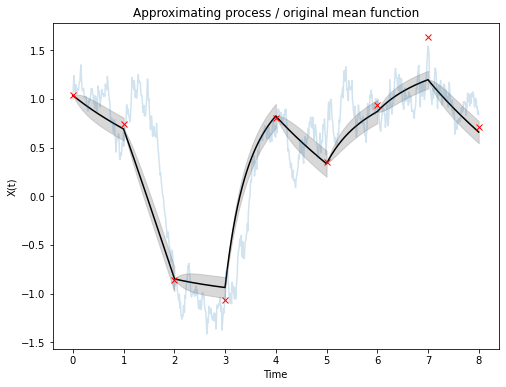

In [30]:
plt.figure(figsize=(8,6))
plt.plot(vp_pts, vp_mean, color='black')
plt.fill_between(vp_pts, vp_mean + vp_std, vp_mean - vp_std, alpha=0.3, color='grey')
plt.plot(true_sde_pts, true_sde_trj, alpha=0.2)
plt.plot(obs_time, obs, 'rx')
plt.title("Approximating process / original mean function")
plt.ylabel("X(t)")
plt.xlabel("Time")
plt.show()

Trace plot: parameters

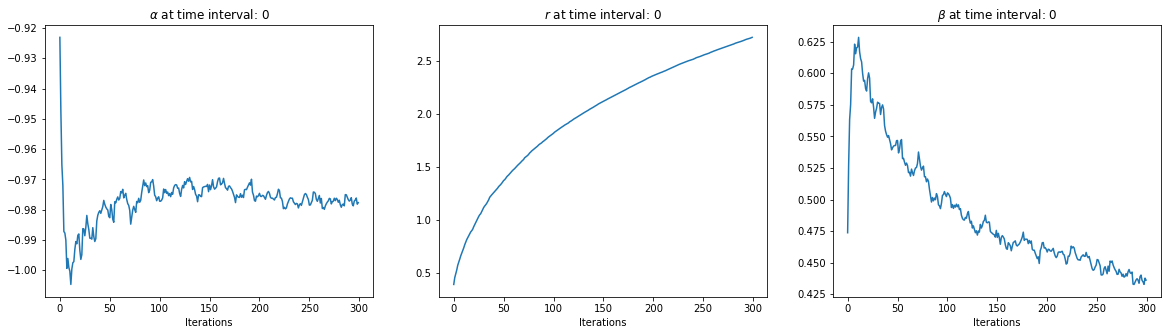

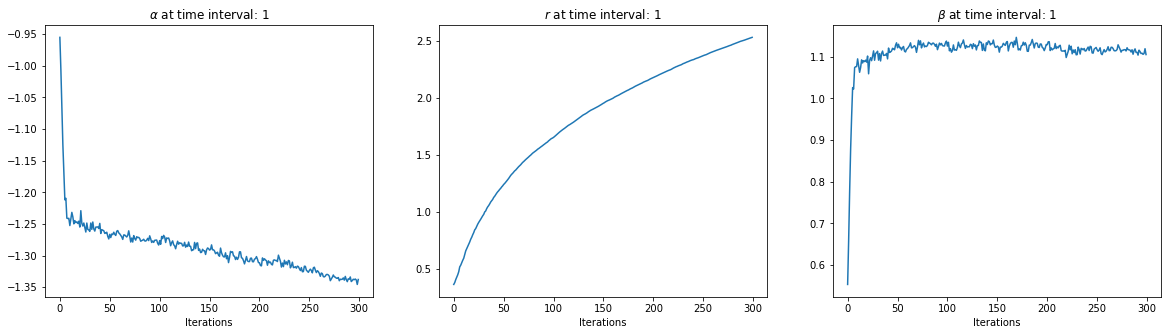

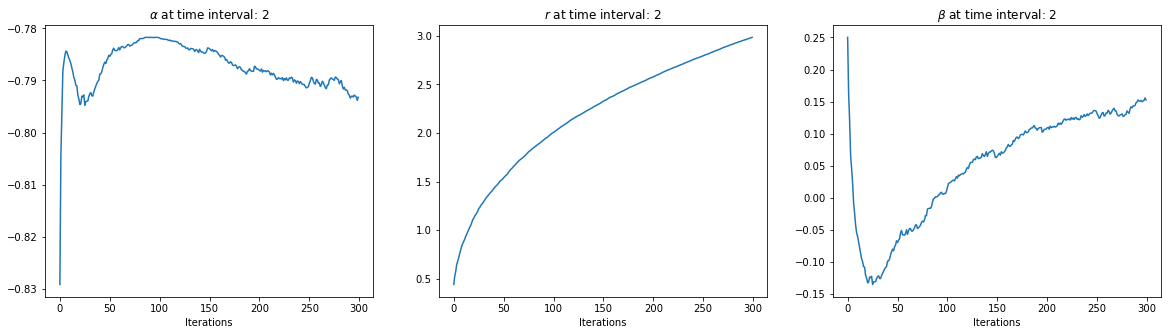

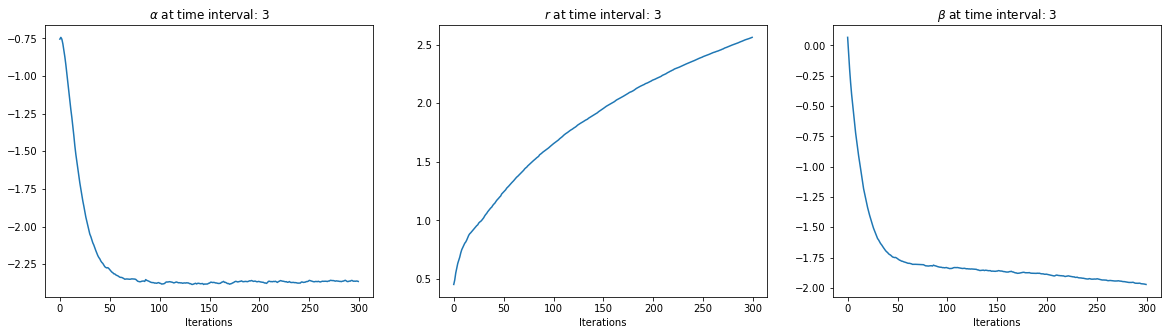

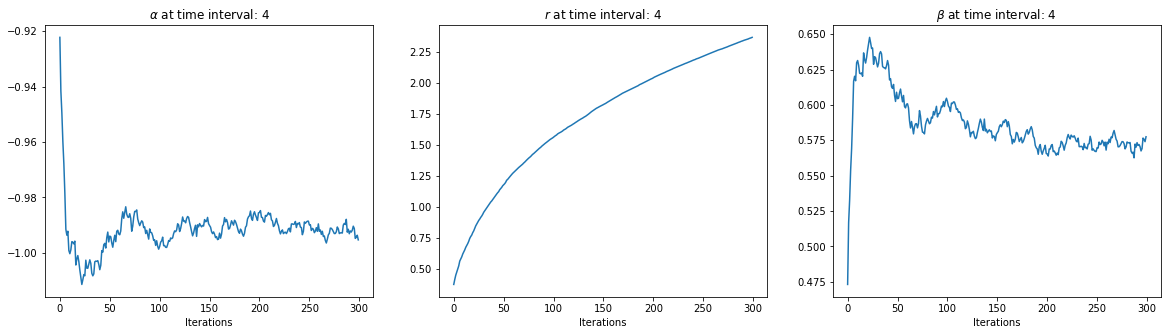

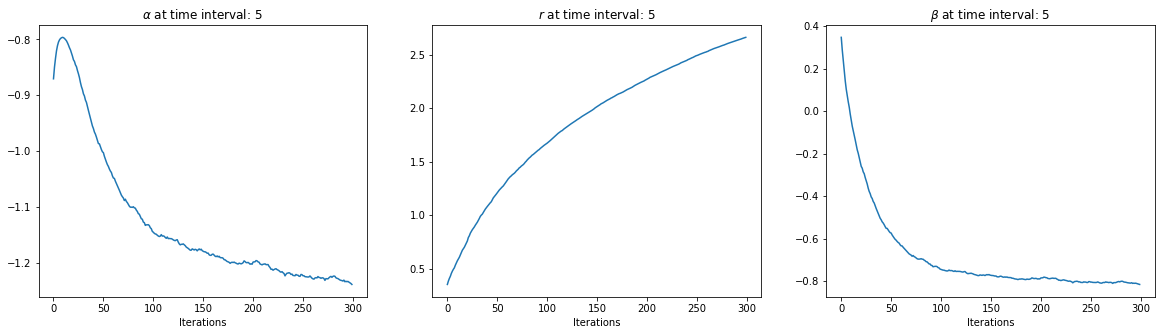

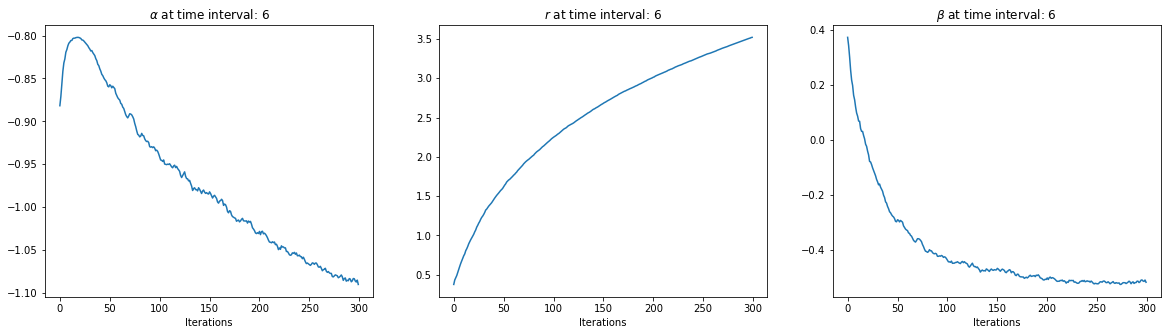

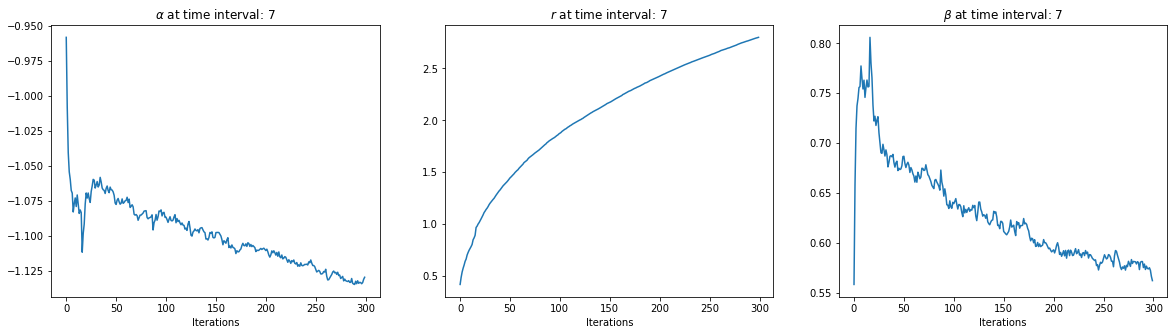

In [28]:
P, T, IT = vp_pars.shape

for t in range(T):
    fig, ax = plt.subplots(nrows=1, ncols=P, figsize=(20, 5))
    names = [r'$\alpha$', '$r$', r'$\beta$']
    for j, ax in enumerate(ax.ravel()):
        ax.plot(np.arange(IT), vp_pars[j, t, :])
        ax.set_title(names[j] + " at time interval: %d" % t)
        ax.set_xlabel("Iterations")
    plt.show()

Examine the convergence by gradually increasing the number of gradient steps

In [29]:
output = []
for it in tq.tqdm([1000, 5000, 10000]):
    vp__pts, vp__mean, vp__std, vp__pars = Optimize(torch.tensor([sde_sigma]), obs, obs_time, obs_sigma, M=1000, IT=it, vN=200, learning_rate=0.001, Linear = False, IsAda=False)
    output.append([vp__pts, vp__mean, vp__std, vp__pars])

  0%|                                                     | 0/8 [00:00<?, ?it/s]

0 {'alpha': tensor(-0.3284), 'beta': tensor(1.0346), 'r': tensor(0.4026)}
500 {'alpha': tensor(-0.4176, dtype=torch.float64), 'beta': tensor(0.8539, dtype=torch.float64), 'r': tensor(3.2678, dtype=torch.float64)}



 12%|█████▋                                       | 1/8 [01:04<07:28, 64.11s/it]

observation: 0.7418740051633642 variational mean: 0.7253071357233278
0 {'alpha': tensor(-0.3284), 'beta': tensor(1.0346), 'r': tensor(0.4026)}
500 {'alpha': tensor(-1.0812, dtype=torch.float64), 'beta': tensor(1.3123, dtype=torch.float64), 'r': tensor(3.0677, dtype=torch.float64)}



 25%|███████████▎                                 | 2/8 [02:08<06:24, 64.13s/it]

observation: -0.8564873337841266 variational mean: -0.8756417036056519
0 {'alpha': tensor(-0.3284), 'beta': tensor(1.0346), 'r': tensor(0.4026)}
500 {'alpha': tensor(-0.0971, dtype=torch.float64), 'beta': tensor(0.9336, dtype=torch.float64), 'r': tensor(3.5811, dtype=torch.float64)}



 38%|████████████████▉                            | 3/8 [03:10<05:16, 63.20s/it]

observation: -1.0673319792395932 variational mean: -0.9957972168922424
0 {'alpha': tensor(-0.3284), 'beta': tensor(1.0346), 'r': tensor(0.4026)}
500 {'alpha': tensor(1.2509, dtype=torch.float64), 'beta': tensor(1.2980, dtype=torch.float64), 'r': tensor(3.0306, dtype=torch.float64)}



 50%|██████████████████████▌                      | 4/8 [04:12<04:10, 62.64s/it]

observation: 0.7995340035602375 variational mean: 0.8569679856300354
0 {'alpha': tensor(-0.3284), 'beta': tensor(1.0346), 'r': tensor(0.4026)}
500 {'alpha': tensor(-0.4933, dtype=torch.float64), 'beta': tensor(1.0406, dtype=torch.float64), 'r': tensor(2.8453, dtype=torch.float64)}



 62%|████████████████████████████▏                | 5/8 [05:13<03:06, 62.28s/it]

observation: 0.3540452486520327 variational mean: 0.3385413885116577
0 {'alpha': tensor(-0.3284), 'beta': tensor(1.0346), 'r': tensor(0.4026)}
500 {'alpha': tensor(0.4653, dtype=torch.float64), 'beta': tensor(1.1585, dtype=torch.float64), 'r': tensor(3.2072, dtype=torch.float64)}



 75%|█████████████████████████████████▊           | 6/8 [06:15<02:04, 62.16s/it]

observation: 0.9328201877376548 variational mean: 0.911328136920929
0 {'alpha': tensor(-0.3284), 'beta': tensor(1.0346), 'r': tensor(0.4026)}
500 {'alpha': tensor(0.2144, dtype=torch.float64), 'beta': tensor(1.4126, dtype=torch.float64), 'r': tensor(4.3047, dtype=torch.float64)}



 88%|███████████████████████████████████████▍     | 7/8 [07:17<01:01, 61.98s/it]

observation: 1.6311081388826472 variational mean: 1.3787981271743774
0 {'alpha': tensor(-0.3284), 'beta': tensor(1.0346), 'r': tensor(0.4026)}
500 {'alpha': tensor(-1.1511, dtype=torch.float64), 'beta': tensor(0.7326, dtype=torch.float64), 'r': tensor(3.5469, dtype=torch.float64)}



 33%|██████████████▋                             | 1/3 [08:19<16:38, 499.08s/it]

observation: 0.708966867981579 variational mean: 0.6404337882995605



  0%|                                                     | 0/8 [00:00<?, ?it/s]

0 {'alpha': tensor(-0.0936), 'beta': tensor(-0.1524), 'r': tensor(1.2266)}
2500 {'alpha': tensor(0.6663, dtype=torch.float64), 'beta': tensor(-0.8608, dtype=torch.float64), 'r': tensor(5.3921, dtype=torch.float64)}



 12%|█████▌                                      | 1/8 [05:01<35:09, 301.37s/it]

observation: 0.7418740051633642 variational mean: 0.7365135241968386
0 {'alpha': tensor(-0.0936), 'beta': tensor(-0.1524), 'r': tensor(1.2266)}
2500 {'alpha': tensor(1.7298, dtype=torch.float64), 'beta': tensor(-4.2961, dtype=torch.float64), 'r': tensor(5.5293, dtype=torch.float64)}



 25%|███████████                                 | 2/8 [10:01<30:03, 300.51s/it]

observation: -0.8564873337841266 variational mean: -0.9322282075881958
0 {'alpha': tensor(-0.0936), 'beta': tensor(-0.1524), 'r': tensor(1.2266)}
2500 {'alpha': tensor(0.3832, dtype=torch.float64), 'beta': tensor(-0.3484, dtype=torch.float64), 'r': tensor(6.0090, dtype=torch.float64)}



 38%|████████████████▌                           | 3/8 [15:08<25:18, 303.67s/it]

observation: -1.0673319792395932 variational mean: -1.0397069454193115
0 {'alpha': tensor(-0.0936), 'beta': tensor(-0.1524), 'r': tensor(1.2266)}
2500 {'alpha': tensor(-1.9766, dtype=torch.float64), 'beta': tensor(-5.1039, dtype=torch.float64), 'r': tensor(5.4579, dtype=torch.float64)}


 33%|██████████████▎                            | 1/3 [26:51<53:43, 1611.71s/it]


KeyboardInterrupt: 

In [ ]:
it_names = ['1000', '5000', '10000']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    P, T, IT = vp__pars.shape

    for t in range(T):
        fig, ax = plt.subplots(nrows=1, ncols=P, figsize=(20, 5))
        names = [r'$\alpha$', '$r$', r'$\beta$']
        for j, ax in enumerate(ax.ravel()):
            ax.plot(np.arange(IT), vp__pars[j, t, :])
            ax.set_title(names[j] + " at time interval: %d" % t)
            ax.set_xlabel("Iterations")
        title = "original-" + name + "time_" + str(t)
        plt.savefig("figures/" + title)
        plt.show()

In [ ]:
it_names = ['1000', '5000', '10000']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    plt.figure(figsize=(10,6))
    plt.plot(vp__pts, vp__mean, color='black')
    plt.fill_between(vp__pts, vp__mean + vp__std, vp__mean - vp__std, alpha=0.3, color='grey')
    plt.plot(true_sde_pts, true_sde_trj, alpha=0.2)
    plt.plot(obs_time, obs, 'rx')
    title = "approximating processes / iteration: " + name
    plt.title(title)
    file_name = "original-" + "approx_process_" + name
    plt.savefig("figures/" + file_name)
    plt.show()

In [ ]:
import pickle

In [ ]:
prior = [true_sde_pts, true_sde_trj]
likelihood = [obs, obs_time]

In [ ]:
with open('EX03_DW_original.pickle', 'wb') as f:
    pickle.dump(prior, f)
    pickle.dump(likelihood, f)
    pickle.dump(output, f)
    pickle.dump(it_names, f)